https://lionbridge.ai/datasets/5-million-faces-top-15-free-image-datasets-for-facial-recognition/

In [ ]:
import numpy as np
import pandas as pd
from IPython.display import display, HTML 
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation , Input , Conv2D, Flatten, Reshape, Conv2DTranspose, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [ ]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)
print(faces.target_names)
print(faces.images.shape)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)


In [ ]:
faces.target_names

array(['Ariel Sharon', 'Colin Powell', 'Donald Rumsfeld', 'George W Bush',
       'Gerhard Schroeder', 'Hugo Chavez', 'Junichiro Koizumi',
       'Tony Blair'], dtype='<U17')

In [ ]:
labels=[]
labels=faces.target_names

In [ ]:
labels

array(['Ariel Sharon', 'Colin Powell', 'Donald Rumsfeld', 'George W Bush',
       'Gerhard Schroeder', 'Hugo Chavez', 'Junichiro Koizumi',
       'Tony Blair'], dtype='<U17')

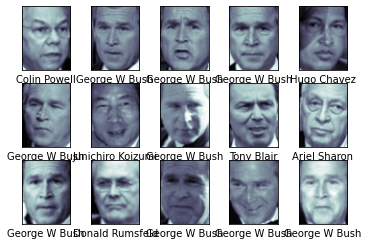

In [ ]:
fig, ax = plt.subplots(3, 5)
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='bone')
    axi.set(xticks=[], yticks=[],
            xlabel=faces.target_names[faces.target[i]])

In [ ]:
x=faces.images
y=faces.target
x.shape , y.shape

((1348, 62, 47), (1348,))

In [ ]:
from skimage.transform import resize
x_resized = resize(x, (1348,52,52))
x_resized.shape

(1348, 52, 52)

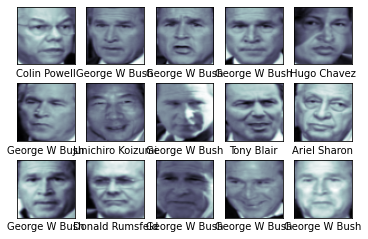

In [ ]:
fig, ax = plt.subplots(3, 5)
for i, axi in enumerate(ax.flat):
    axi.imshow(x_resized[i], cmap='bone')
    axi.set(xticks=[], yticks=[],
            xlabel=faces.target_names[faces.target[i]])

In [ ]:
np.max(x_resized[0])

196.64688

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
x_resized = x_resized.astype('float32') / 255

X_train, X_test, y_train, y_test = train_test_split(x_resized, y, test_size=0.10, random_state=42)

In [ ]:
inputs = Input(shape=(52,52,1), name='encoder_input')
x = Conv2D( filters=32, kernel_size=3,activation='relu', strides=2, padding='same')(inputs)
x = BatchNormalization()(x)
x = Conv2D( filters=64, kernel_size=3,activation='relu', strides=2, padding='same')(x)
x_shape=x.shape.as_list()
x = Flatten()(x)
enc_out = Dense(32)(x)
encoder = Model(inputs,enc_out,name='encoder')
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 52, 52, 1)]       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization_3 (Batch (None, 26, 26, 32)        128       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
flatten_2 (Flatten)          (None, 10816)             0         
_________________________________________________________________
dense_20 (Dense)             (None, 32)                346144    
Total params: 365,088
Trainable params: 365,024
Non-trainable params: 64
____________________________________________________

In [ ]:
x_shape

[None, 13, 13, 64]

In [ ]:
dec_input= Input(shape=(32), name='decoder_input')
x= Dense(x_shape[1]*x_shape[2]*x_shape[3])(dec_input)
x=Reshape((x_shape[1],x_shape[2],x_shape[3]))(x)
x = Conv2DTranspose(filters=64, kernel_size=3, activation='relu', strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = Conv2DTranspose(filters=32, kernel_size=3, activation='relu', strides=2, padding='same')(x)
output = Conv2DTranspose(filters=1, kernel_size=3, activation='sigmoid', padding='same')(x)
decoder = Model(dec_input,output,name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 32)]              0         
_________________________________________________________________
dense_21 (Dense)             (None, 10816)             356928    
_________________________________________________________________
reshape_1 (Reshape)          (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 26, 26, 64)        36928     
_________________________________________________________________
batch_normalization_4 (Batch (None, 26, 26, 64)        256       
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 52, 52, 32)        18464     
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 52, 52, 1)         289 

In [ ]:
class_input=Input(shape=32, name='classifier')
x = Dense(512,activation='relu')(class_input)
x = Dense(256,activation='relu')(x)
x = Dense(128,activation='relu')(x)
class_output= Dense(8,activation='softmax')(x)
classifier = Model(class_input, class_output, name='classifier')
classifier.summary()

Model: "classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
classifier (InputLayer)      [(None, 32)]              0         
_________________________________________________________________
dense_22 (Dense)             (None, 512)               16896     
_________________________________________________________________
dense_23 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_24 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_25 (Dense)             (None, 8)                 1032      
Total params: 182,152
Trainable params: 182,152
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from keras.utils import plot_model

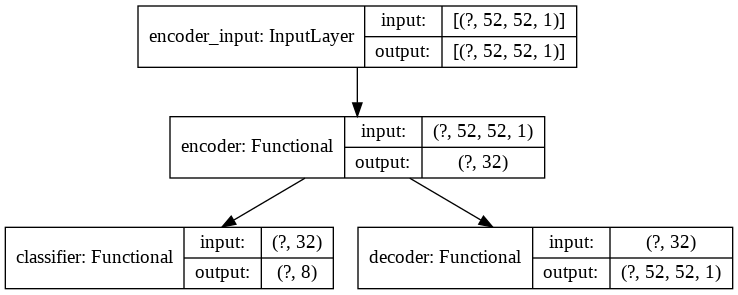

In [ ]:
autoencoder = Model(inputs,[classifier(encoder(inputs)), decoder(encoder(inputs))],name='autodecoder')

plot_model(autoencoder, show_shapes=True)


In [ ]:
import tensorflow as tf

In [ ]:
callback=tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto',
    baseline=None, restore_best_weights=True
)

In [ ]:
y_train[0]

3

In [ ]:
autoencoder.compile(loss=['SparseCategoricalCrossentropy', 'mse'],
                    optimizer='adam',
                    metrics=['accuracy', 'mse'])

In [ ]:
autoencoder.fit(X_train, [y_train, X_train], validation_data=(X_test, [y_test, X_test]), epochs= 100)

Epoch 1/100
38/38 [==============================] - 1s 21ms/step - loss: 1.5123 - classifier_loss: 1.4937 - decoder_loss: 0.0186 - classifier_accuracy: 0.4864 - classifier_mse: 12.5862 - decoder_accuracy: 9.7562e-06 - decoder_mse: 0.0186 - val_loss: 1.9199 - val_classifier_loss: 1.8887 - val_decoder_loss: 0.0313 - val_classifier_accuracy: 0.5926 - val_classifier_mse: 14.4789 - val_decoder_accuracy: 0.0000e+00 - val_decoder_mse: 0.0313
Epoch 2/100
38/38 [==============================] - 0s 10ms/step - loss: 0.6096 - classifier_loss: 0.5947 - decoder_loss: 0.0148 - classifier_accuracy: 0.8021 - classifier_mse: 12.6297 - decoder_accuracy: 1.8903e-05 - decoder_mse: 0.0148 - val_loss: 1.6215 - val_classifier_loss: 1.5906 - val_decoder_loss: 0.0309 - val_classifier_accuracy: 0.7556 - val_classifier_mse: 14.4809 - val_decoder_accuracy: 0.0000e+00 - val_decoder_mse: 0.0309
Epoch 3/100
38/38 [==============================] - 0s 10ms/step - loss: 0.2576 - classifier_loss: 0.2440 - decoder_los

In [ ]:
X_test.shape

(135, 52, 52)

In [ ]:
y_predict=autoencoder.predict(X_test[0].reshape(1,52,52))

In [ ]:
len(y_predict)

2

In [ ]:
y_predict[1].shape

(1, 52, 52, 1)

In [ ]:
np.argmax(y_predict[0])

3

In [ ]:
y_test.shape

(135,)

In [ ]:
y_test[0]

3

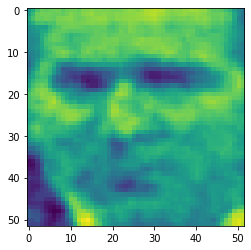

In [ ]:
plt.imshow(y_predict[1].reshape(52,52))

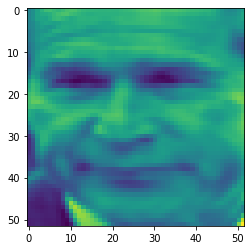

In [ ]:
plt.imshow(X_test[0])